In [3]:
# Load the needed python libraries by executing this python code (press ctrl enter)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import networkx as nx
from scipy import stats

In [4]:
df = pd.read_csv("CombineROSINA_RowAB_new.log", sep="\t")
#print(df.head()) # Print the first five rows
print(df.describe())

# Open the tab-separated file and read the first row (header)
with open("CombineROSINA_RowAB_new.log", newline='', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')  # use tab as delimiter
    header = next(reader)  # get the first line
    header_slice = header[13:38] #use header_slice as set
    #print(header_slice)

       AcquisitionTimeEt [s]  DistCGSC [km]  DistCGSUN [au]  NadirAngle [deg]  \
count           4.540320e+05  454032.000000   454032.000000     454032.000000   
mean            4.935478e+08     102.025748        2.471913          3.248503   
std             2.017161e+07     116.135904        0.795915          4.080776   
min             4.601596e+08       3.900000        1.243000          0.000000   
25%             4.747050e+08      22.860000        1.686000          0.640000   
50%             4.937398e+08      48.540000        2.515000          1.900000   
75%             5.103436e+08     143.150000        3.212000          4.210000   
max             5.284972e+08    1265.680000        3.833000         43.430000   

       SunAngle [deg]      Lon [deg]      Lat [deg]  LocalTime [h]  \
count   454032.000000  454032.000000  454032.000000  454032.000000   
mean        97.653538      -0.952262       3.671390      12.183173   
std         19.320601     103.903907      41.346831       5.

In [5]:
# create empty dataframe and fill it with scaled columns
df_empty = pd.DataFrame()
for i in header_slice:
    scaled_column = df[i] * df["DistCGSC [km]"]**2 * (100000)**2 # *r^2*km->cm-rescale-factor
    df_empty[i] = scaled_column   # assign column directly/fill df_empty

#### get rid of 0 -> maintain original 0.00001 and log-scale to emphasize small values
df_scaled = np.log10(df_empty.replace(0, 1))

#### CHECK: first value of water (H2O) (dist=845km=84500000cm, density(H2O)=627'000ccm)
#density scaled (log10 and *r^2) = 21.65
#print(df_scaled.head())

In [6]:
# timestamp join
df_scaled["time_stamp"] = pd.to_datetime(df["AcquisitionTime"])
#df_scaled["time_stamp"].dt.strftime("%d-%m-%Y, %r")
#print(df_scaled.tail())

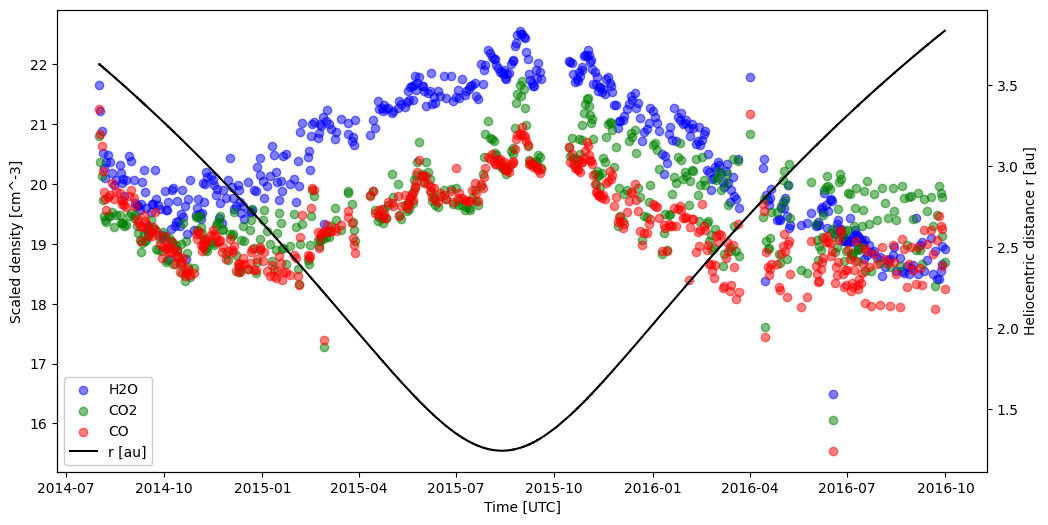

In [9]:
##### PLOT 0: density versus time for main species
fig, ax1 = plt.subplots(figsize=(12,6))

# --- left y-axis (densities) ---
ax1.scatter(df_scaled["time_stamp"][::1000], df_scaled['nH2O [cm^-3]'][::1000],
            c='b', label='H2O', alpha=0.5)
ax1.scatter(df_scaled["time_stamp"][::1000], df_scaled['nCO2 [cm^-3]'][::1000],
            c='g', label='CO2', alpha=0.5)
ax1.scatter(df_scaled["time_stamp"][::1000], df_scaled['nCO [cm^-3]'][::1000],
            c='r', label='CO', alpha=0.5)

ax1.set_xlabel("Time [UTC]")
ax1.set_ylabel("Scaled density [cm^-3]")

# --- right y-axis (heliocentric distance r) ---
ax2 = ax1.twinx()
ax2.plot(pd.to_datetime(df["AcquisitionTime"]), df["DistCGSUN [au]"],
         color="black", linewidth=1.5, label="r [au]")
ax2.set_ylabel("Heliocentric distance r [au]")

# --- x-ticks formatting ---
plt.xticks(rotation=90, ha="right")

# --- combine legends from both axes ---
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="lower left", framealpha=1, facecolor="white")
plt.savefig("density-time-series.png", dpi=300, bbox_inches="tight")
plt.show()


In [10]:
### set time-stamp as index of df_scaled
df_scaled.set_index(["time_stamp"], drop=True, inplace=True)

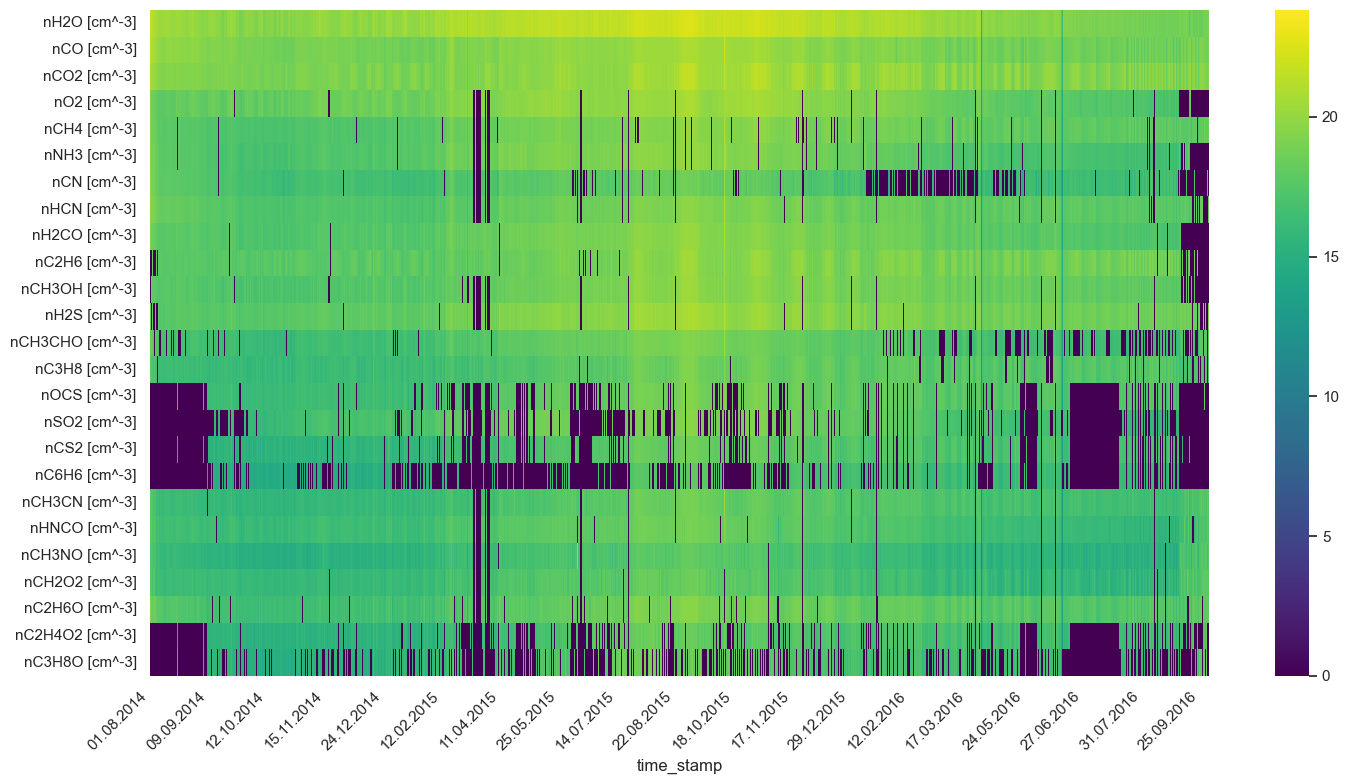

In [12]:
###### PLOT 1: heat map

sns.set_theme()
plt.figure(figsize=(15,8))
#sns.heatmap(df_scaled.select_dtypes(include="number").head(1000).transpose(),cmap="coolwarm")
sns.heatmap(df_scaled.select_dtypes(include="number").transpose(),cmap="viridis")

plt.xticks(ticks=range(0, len(df_scaled), 25000), 
           labels=df_scaled.index[::25000].strftime('%d.%m.%Y'), 
           rotation=45, ha="right")  # Rotieren der x-Labels
plt.tight_layout()  # ensures labels fit inside canvas
plt.savefig("heatmap_all.png", dpi=300)  # save as PNG, high resolution
plt.show()


In [13]:
#### DESCRIPTION: Pearson correlation matrix from df_scaled
df_scaled_species = df_scaled.reset_index(drop=True)
# df_scaled_species = df_scaled.drop(["time_stamp"], axis=1) # use if time-stamp not index
# print(df_scaled.head())
# print(df_scaled_species.head())

# Pearson correlation
corr_matrix = df_scaled_species.corr(method='pearson')
# print(corr_matrix)

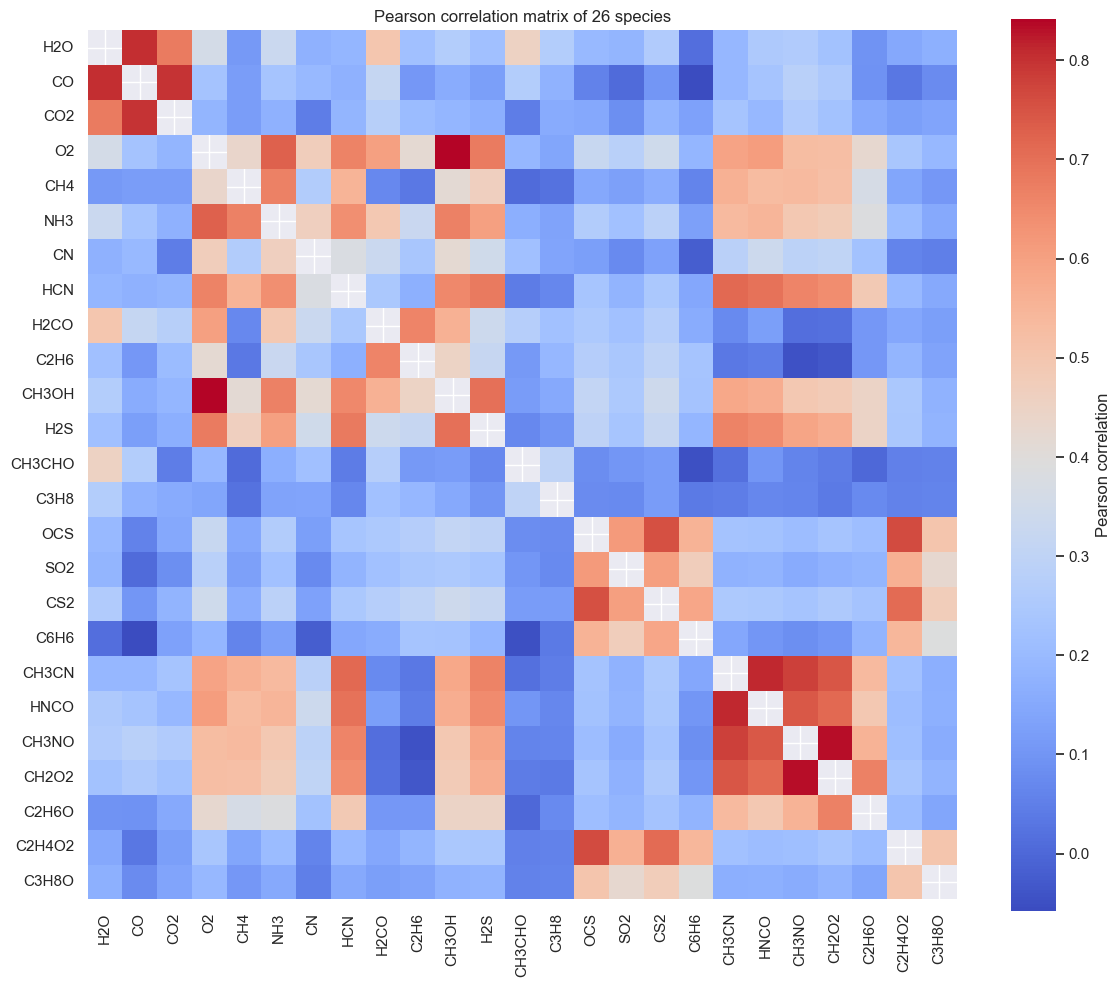

In [14]:
###### PLOT 2: pearson correlation heat map
# Create a custom colormap: blue -> white -> red
#cmap = LinearSegmentedColormap.from_list("blue_white_red", ["blue", "white", "red"])

# Mask the diagonal to white
mask = np.eye(len(corr_matrix), dtype=bool)

# Clean axis labels from df_scaled: remove unit in brackets and leading 'n'
clean_labels = [col.split(' ')[0] for col in df_scaled.columns]  # remove unit
clean_labels = [label[1:] if label.startswith('n') else label for label in clean_labels]  # remove 'n'

plt.figure(figsize=(12,10))
ax = sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", mask=mask,
            cbar_kws={"label": "Pearson correlation"}, square=True)

# Get the tick positions automatically
xticks = ax.get_xticks()
yticks = ax.get_yticks()

# Make sure the number of labels matches number of ticks
ax.set_xticklabels(clean_labels[:len(xticks)], rotation=90)
ax.set_yticklabels(clean_labels[:len(yticks)], rotation=0)

plt.savefig("corr_matrix.png", dpi=300)
plt.title("Pearson correlation matrix of 26 species")
plt.tight_layout()
plt.show()


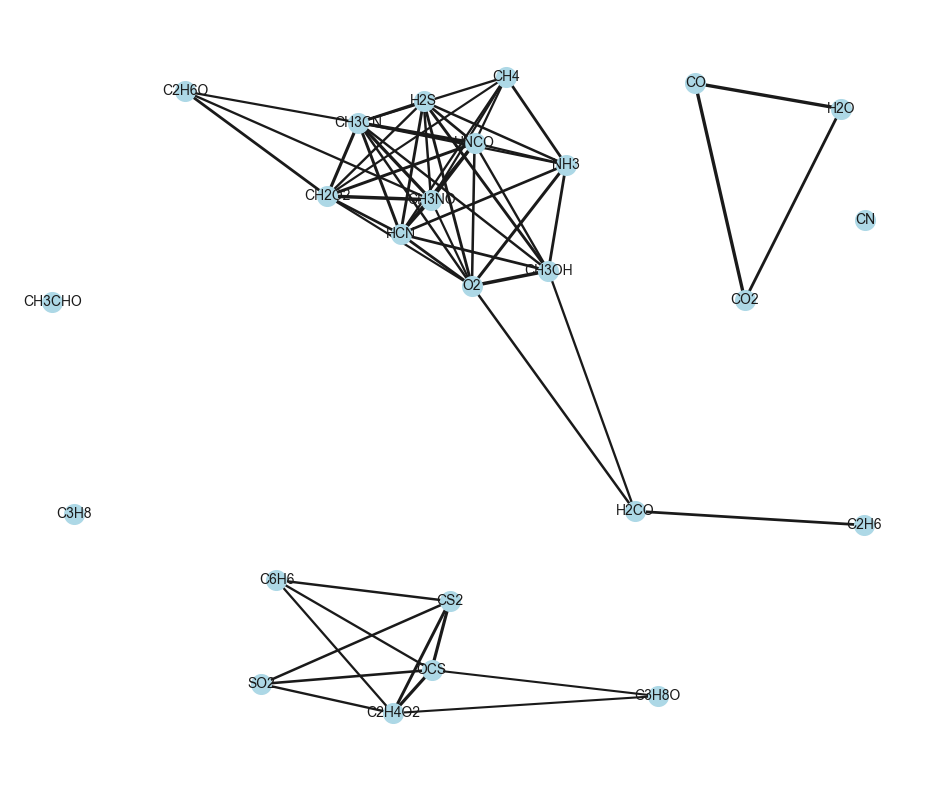

In [15]:
###### PLOT 3: pearson correlation matrix as network
G = nx.Graph()

# Prepare cleaned labels
clean_labels = [col.split(' ')[0] for col in df_scaled.columns]  # remove unit
clean_labels = [label[1:] if label.startswith('n') else label for label in clean_labels]  # remove 'n'

# Create a mapping from original columns to cleaned labels
label_map = dict(zip(corr_matrix.columns, clean_labels))

# Add nodes using cleaned labels
for col in corr_matrix.columns:
    G.add_node(label_map[col])

# Add edges (upper triangle, threshold)
threshold = 0.5
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        corr = corr_matrix.iloc[i, j]
        if abs(corr) > threshold:
            G.add_edge(label_map[corr_matrix.index[i]], 
                       label_map[corr_matrix.columns[j]], 
                       weight=corr)

# Layout and draw
pos = nx.spring_layout(G, k=0.8)
edges = G.edges(data=True)
weights = [d['weight'] for (u,v,d) in edges]

plt.figure(figsize=(12,10))
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, width=[abs(w)*3 for w in weights])
plt.axis('off')
plt.savefig("network-from-corr.png", dpi=300)
plt.show()


In [31]:
# equinoxes:
# inbound equinox (Tubiana, Rinaldi, Güttler, Snodgrass, Shi, etc., 2019): 27 April 2015, at 1.76 AU
# according to Luspay-Kuti et al. A&A 630, A30 (2019)
# inbound equinox (10 May 2015)
# outbound equinox (21 March 2016)

# make sub-dfs and slice plus-minus 14d before and after equinoxes


# user input date
date_inbound = pd.to_datetime("2015-05-10")
date_outbound = pd.to_datetime("2016-03-21")

# interval in days
delta = pd.Timedelta(days=7)

# filter the DataFrame
df_inbound = df_scaled.loc[(df_scaled.index >= date_inbound - delta) & (df_scaled.index <= date_inbound + delta)]
df_outbound = df_scaled.loc[(df_scaled.index >= date_outbound - delta) & (df_scaled.index <= date_outbound + delta)]
# print(df_inbound.describe()) # count  16962
# print(df_outbound.describe()) # count  12531

df_inbound_means = df_inbound.mean(axis=0)
df_outbound_means = df_outbound.mean(axis=0)
# print(df_inbound_means.head())

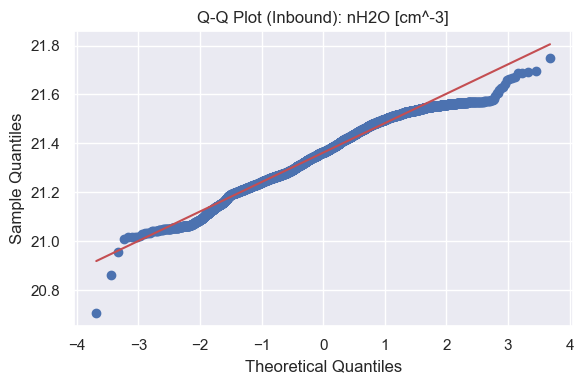

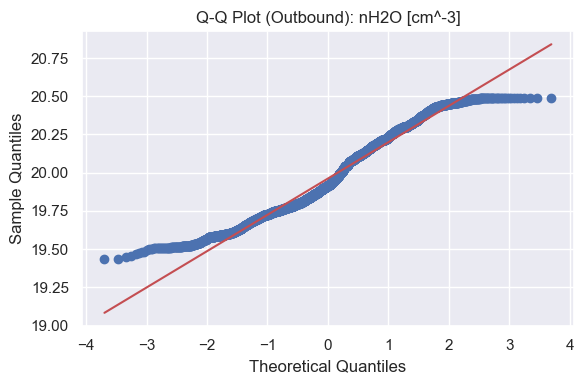

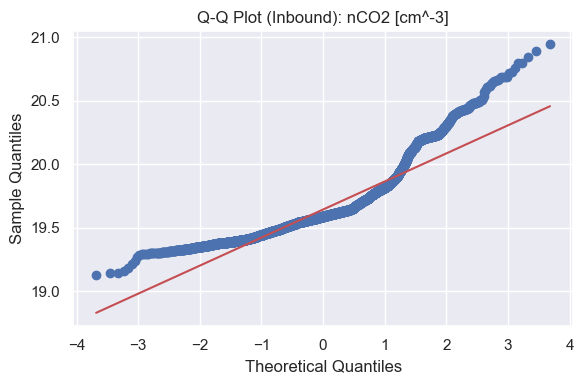

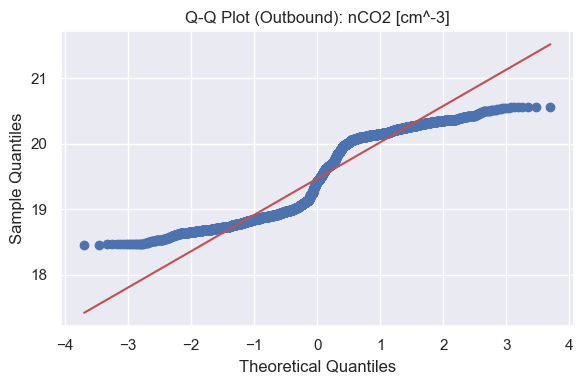

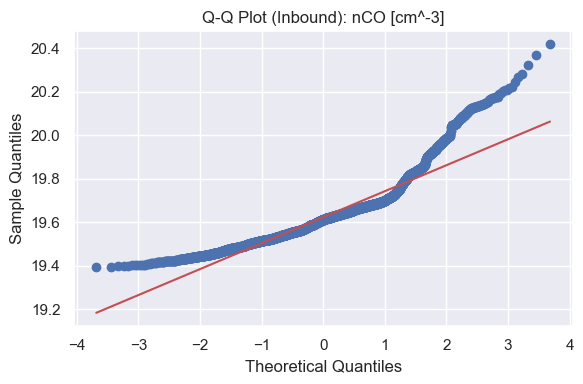

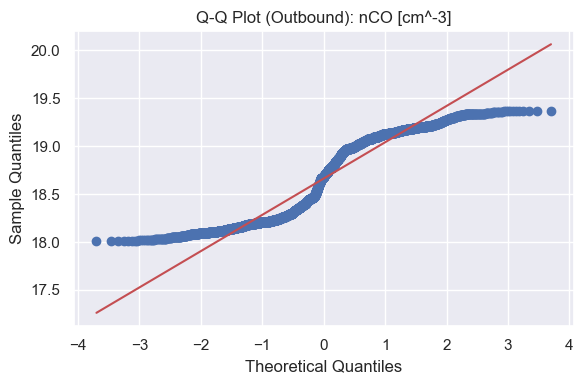

In [32]:
species_list = ['nH2O [cm^-3]', 'nCO2 [cm^-3]', 'nCO [cm^-3]']

for species in species_list:
    # Inbound
    plt.figure(figsize=(6, 4))
    stats.probplot(df_inbound[species], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot (Inbound): {species}')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.tight_layout()
    plt.show()

    # Outbound
    plt.figure(figsize=(6, 4))
    stats.probplot(df_outbound[species], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot (Outbound): {species}')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.tight_layout()
    plt.show()

In [ ]:
# Hypothesentest
# When comparing two datasets that do not follow a normal distribution and have different sample sizes, it's advisable to use non-parametric tests. Non-parametric tests do not assume a specific distribution for the data and are suitable for smaller sample sizes or data that violate the assumptions of normality. Here are two commonly used non-parametric tests: Mann-Whitney U Test (Wilcoxon Rank-Sum Test)

# Unpaired
# not normal distributed
# independent as we do not have paired samples... and comet changed as ice melted inbetween

# takes the ranked sums

In [33]:
from scipy.stats import mannwhitneyu

species_list = ['nH2O [cm^-3]', 'nCO2 [cm^-3]', 'nCO [cm^-3]']

for species in species_list:
    inbound_data = df_inbound[species].dropna()
    outbound_data = df_outbound[species].dropna()
    stat, p_value = mannwhitneyu(inbound_data, outbound_data, alternative='two-sided')
    print(f"{species}: U={stat:.2f}, p-value={p_value:.3e}")

nH2O [cm^-3]: U=38599055.00, p-value=0.000e+00
nCO2 [cm^-3]: U=22338331.00, p-value=3.784e-52
nCO [cm^-3]: U=38599055.00, p-value=0.000e+00
